In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

## Load the data

In [2]:
df = pd.read_csv('../cleaned_data/FREN.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,,,,,,,
2012-10-17,0.262912,0.323930,0.330964,-0.283181,1.816790,2.044664,2.114615,0.901276,1.086567,1.104971,0.0,0.5,0.5,-1.0,0.594005,0.066667,0.592593,0.992469
2012-10-18,0.363756,0.367853,0.372052,2.890247,0.762637,1.044525,1.193857,0.927216,1.134364,1.199147,0.5,0.5,0.5,-1.0,0.599455,0.133333,0.592593,0.659136
2012-10-19,0.421380,0.384324,0.390179,3.048546,0.943685,1.220859,1.368199,0.490172,0.559098,0.597600,1.0,0.5,0.5,-1.0,0.604905,0.200000,0.592593,0.787341
2012-10-22,0.497013,0.413606,0.413140,3.232585,0.871368,1.153974,1.305792,0.334589,0.356089,0.297172,-1.0,0.5,0.5,-1.0,0.621253,0.400000,0.629630,0.761700
2012-10-23,0.561840,0.442888,0.425224,3.196894,0.645525,0.952478,1.119480,0.295777,0.309812,0.308451,-0.5,0.5,0.5,-1.0,0.626703,0.466667,0.629630,0.684777


### Plot the Close price - our target

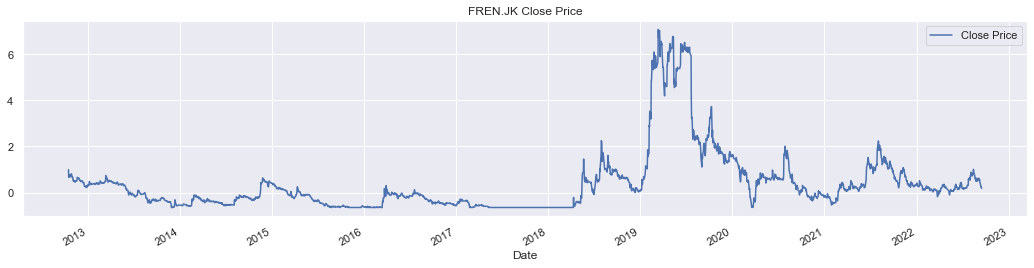

In [3]:
df['Close'].plot(figsize=(18, 4))
plt.legend(['Close Price'])
plt.title('FREN.JK Close Price')
plt.show()

### Split the data
- Split the data into independent variables and target variable
- Split the data into train and test set (80:20)

In [4]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [5]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Close')
test_labels = test_features.pop('Close')

## Understanding Time Series Data

### Decompose time series into Trend, Seasonality, and Random Noise

In [6]:
import statsmodels.api as sm

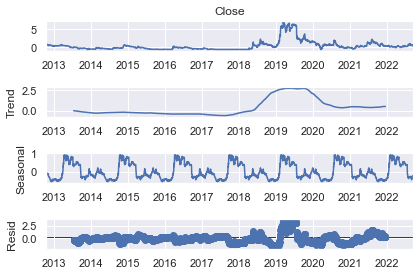

In [7]:
seas_d = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=365)
fig = seas_d.plot()
plt.show()

### ADF Test to check stationarity of the data

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [9]:
test_adf(df['Close'], 'Stock Close Price')

Strong evidence for Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Stock Close Price


In [10]:
"""
The Close price is not stationary. 
Therefore, differencing needs to be performed
"""
test_adf(df['Close'].diff(), 'Stock Close Price - First Difference')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Stock Close Price - First Difference


### Plot ACF (Autocorrelation) and PACF (Partial Autocorrelation)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


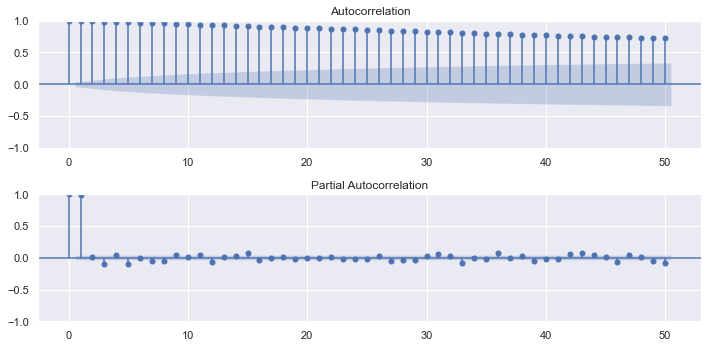

In [11]:
fig, ax = plt.subplots(2,1, figsize=(10,5))

fig = sm.tsa.graphics.plot_acf(df['Close'], lags=50, ax=ax[0])

fig = sm.tsa.graphics.plot_pacf(df['Close'], lags=50, ax=ax[1])
plt.tight_layout()
plt.show()

## Build the SARIMAX model

### Use auto_arima to determine the optimal p,d,q orders
We can determine p,d,q orders by using ACF and PACF plots above. However, a stepwise search will enable us to try out more optimal p,d,q orders.

In [12]:
from pmdarima.arima import auto_arima

In [13]:
step_wise_exog = auto_arima(train_labels, exogenous= train_features,
                           start_p=1, start_q=1, 
                           max_p=7, max_q=7, 
                           d=None, D=1, test='adf', max_d=7, seasonal=True, m=5,
                           trace=True, 
                           error_action='ignore', 
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[5] intercept   : AIC=inf, Time=3.04 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=1218.590, Time=0.24 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=-1352.771, Time=0.93 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=105.699, Time=0.63 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=1216.609, Time=0.14 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=-915.938, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=-1605.890, Time=1.54 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=3.44 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=1185.304, Time=1.29 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=-1604.824, Time=2.12 sec
 ARIMA(1,0,1)(2,1,0)[5] intercept   : AIC=-1604.618, Time=2.09 sec
 ARIMA(0,0,1)(2,1,0)[5] intercept   : AIC=107.596, Time=1.05 sec
 ARIMA(2,0,1)(2,1,0)[5] intercept   : AIC=-1619.752, Time=4.69 sec
 ARIMA(2,0,1)(1,1,0)[5] intercept   : AIC=-13

In [14]:
step_wise_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1967
Model:             SARIMAX(3, 0, 2)x(0, 1, 2, 5)   Log Likelihood                1021.206
Date:                           Wed, 23 Nov 2022   AIC                          -2024.412
Time:                                   20:28:06   BIC                          -1974.176
Sample:                                        0   HQIC                         -2005.948
                                          - 1967                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.178e-05      0.000      0.246      0.805      -0.000       0.001
ar.L1          0.8351      0.205      4.071      0.000       0.433       1.237
ar.L2          0.1891      0.206      0.917      0.359      -0.215       0.593
ar.L3         -0.0310      0.138     -0.224      0.822      -0.302       0.240
ma.L1          0.1383      0.207      0.670      0.503      -0.267       0.543
ma.L2          0.0381      0.135      0.283      0.777      -0.226       0.302
ma.S.L5       -0.9463      0.012    -76.556      0.000      -0.971      -0.922
ma.S.L10      -0.0007      0.012     -0.063      0.950      -0.024       0.022
sigma2         0.0203      0.000    128.017      0.000       0.020       0.021
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):            177871.64
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):              22.03   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

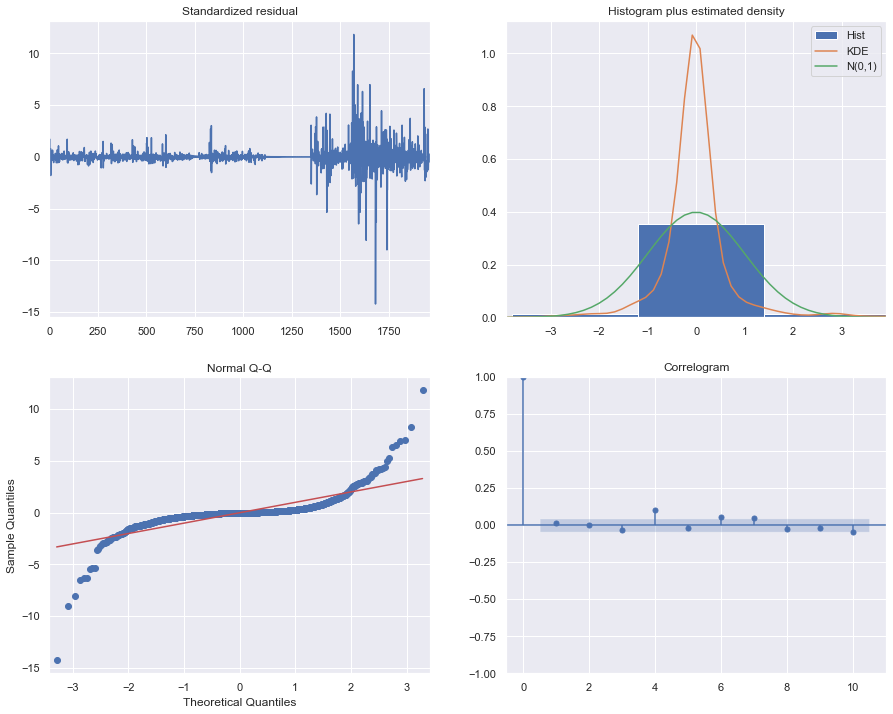

In [16]:
step_wise_exog.plot_diagnostics(figsize=(15,12));

### Fit the SARIMAX model using the best p,d,q orders

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [18]:
model_exog = SARIMAX(train_labels, exog=train_features,
                order=(3,0,2), seasonal_order=(0,1,2,5),
                enforce_invertibility=True, enforce_stationarity=True)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [19]:
results = model_exog.fit()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 1967
Model:             SARIMAX(3, 0, 2)x(0, 1, 2, 5)   Log Likelihood                1564.728
Date:                           Wed, 23 Nov 2022   AIC                          -3079.456
Time:                                   20:28:52   BIC                          -2939.913
Sample:                                        0   HQIC                         -3028.169
                                          - 1967                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.5206      0.070      7.416      0.000       0.383       0.658
14 DAYS MA         0.1861      0.116      1.610      0.107      -0.041       0.413
21 DAYS MA         0.2229      0.089      2.501      0.012       0.048       0.398
7 DAYS STD DEV    -0.0244      0.002    -11.779      0.000      -0.029      -0.020
RSI 7             -0.0918      0.016     -5.848      0.000      -0.123      -0.061
RSI 14             0.3611      0.028     12.733      0.000       0.306       0.417
RSI 21             0.0867      0.017      5.245      0.000       0.054       0.119
MFI 7             -0.0071      0.019     -0.375      0.708      -0.045       0.030
MFI 14            -0.0231      0.023     -1.026      0.305      -0.067       0.021
MFI 21            -0.0591      0.015     -3.875      0.000      -0.089      -0.029
dayofweek          0.0004      0.004      0.101      0.920      -0.007       0.008
quarter           -0.0640      0.062     -1.032      0.302      -0.185       0.058
month              0.1257      2.216      0.057      0.955      -4.217       4.469
year              -0.0594      0.305     -0.195      0.846      -0.657       0.539
dayofyear         -0.0850      2.251     -0.038      0.970      -4.497       4.327
dayofmonth         0.0056      0.186      0.030      0.976      -0.360       0.371
weekofyear         0.0282      0.050      0.558      0.577      -0.071       0.127
ar.L1              1.6871      0.304      5.554      0.000       1.092       2.282
ar.L2             -0.7630      0.495     -1.540      0.124      -1.734       0.208
ar.L3              0.0400      0.230      0.174      0.862      -0.411       0.491
ma.L1             -0.8289      0.298     -2.781      0.005      -1.413      -0.245
ma.L2              0.0965      0.264      0.366      0.714      -0.420       0.613
ma.S.L5           -0.9661      0.015    -66.089      0.000      -0.995      -0.937
ma.S.L10           0.0081      0.015      0.541      0.589      -0.021       0.037
sigma2             0.0119      0.000     83.776      0.000       0.012       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):            173666.60
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):              10.73   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions

In [21]:
predictions = results.predict(start=train_len, end=len(df)-1, exog=test_features)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [22]:
actual_close = df[['Close']]
act = pd.DataFrame(actual_close.iloc[train_len:, 0])

In [23]:
predictions = pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index = test_features.index
predictions['Actual'] = act['Close']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)

In [24]:
predictions

,Pred,Actual
Date,,
2020-09-10,0.210587,0.154449
2020-09-11,0.150674,0.128707
2020-09-14,0.233924,0.308897
2020-09-15,0.201264,0.257414
2020-09-16,0.182567,0.231673
...,...,...
2022-09-12,0.503523,0.334639
2022-09-13,0.402639,0.257414
2022-09-14,0.383697,0.257414


<AxesSubplot:xlabel='Date'>

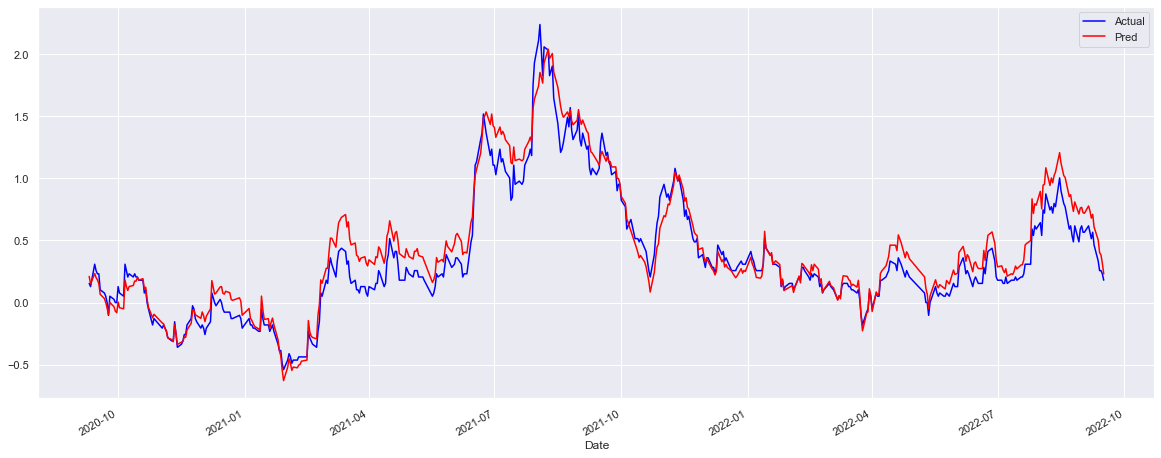

In [25]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

### Evaluation

In [26]:
from joblib import load

In [27]:
close_scaler = load('../feature_engineering/fren_close_scaler.bin')

In [28]:
inversed_pred = close_scaler.inverse_transform(np.array(predictions['Pred']).reshape(-1,1))
inversed_act = close_scaler.inverse_transform(np.array(predictions['Actual']).reshape(-1,1))

In [29]:
inversed = pd.DataFrame(inversed_pred)
inversed['Actual'] = inversed_act
inversed.rename({0:'Pred'}, axis=1, inplace=True)
inversed.index = test_labels.index
inversed.head(2)

,Pred,Actual
Date,,
2020-09-10,83.180862,81.0
2020-09-11,80.853362,80.0


**Plot Error Distribution**

In [30]:
def plotErrorHist(inversed_df):
    """
    Function to plot error histogram
    """
    error = inversed_df['Pred'] - inversed_df['Actual']
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error [Close]')
    _ = plt.ylabel('Count')

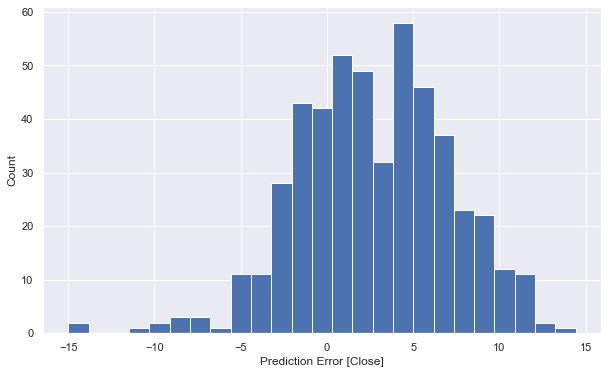

In [31]:
plt.figure(figsize=(10,6))
plotErrorHist(inversed)

**RMSE**

In [32]:
from statsmodels.tools.eval_measures import rmse

In [33]:
rmse(inversed['Pred'], inversed['Actual'])

5.18087043179615

**MAPE**

In [34]:
# mape
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [35]:
mape(inversed['Actual'], inversed['Pred'])

4.574521487271589

**R-squared**

In [36]:
from sklearn.metrics import r2_score

In [37]:
r2_score(inversed['Actual'], inversed['Pred'])

0.9268272615901694

### Save the model

In [38]:
from joblib import dump, load
dump(results, './models/fren.joblib') 

['./models/fren.joblib']

In [39]:
loaded = load('./models/fren.joblib')
loaded.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 1967
Model:             SARIMAX(3, 0, 2)x(0, 1, 2, 5)   Log Likelihood                1564.728
Date:                           Wed, 23 Nov 2022   AIC                          -3079.456
Time:                                   20:28:54   BIC                          -2939.913
Sample:                                        0   HQIC                         -3028.169
                                          - 1967                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.5206      0.070      7.416      0.000       0.383       0.658
14 DAYS MA         0.1861      0.116      1.610      0.107      -0.041       0.413
21 DAYS MA         0.2229      0.089      2.501      0.012       0.048       0.398
7 DAYS STD DEV    -0.0244      0.002    -11.779      0.000      -0.029      -0.020
RSI 7             -0.0918      0.016     -5.848      0.000      -0.123      -0.061
RSI 14             0.3611      0.028     12.733      0.000       0.306       0.417
RSI 21             0.0867      0.017      5.245      0.000       0.054       0.119
MFI 7             -0.0071      0.019     -0.375      0.708      -0.045       0.030
MFI 14            -0.0231      0.023     -1.026      0.305      -0.067       0.021
MFI 21            -0.0591      0.015     -3.875      0.000      -0.089      -0.029
dayofweek          0.0004      0.004      0.101      0.920      -0.007       0.008
quarter           -0.0640      0.062     -1.032      0.302      -0.185       0.058
month              0.1257      2.216      0.057      0.955      -4.217       4.469
year              -0.0594      0.305     -0.195      0.846      -0.657       0.539
dayofyear         -0.0850      2.251     -0.038      0.970      -4.497       4.327
dayofmonth         0.0056      0.186      0.030      0.976      -0.360       0.371
weekofyear         0.0282      0.050      0.558      0.577      -0.071       0.127
ar.L1              1.6871      0.304      5.554      0.000       1.092       2.282
ar.L2             -0.7630      0.495     -1.540      0.124      -1.734       0.208
ar.L3              0.0400      0.230      0.174      0.862      -0.411       0.491
ma.L1             -0.8289      0.298     -2.781      0.005      -1.413      -0.245
ma.L2              0.0965      0.264      0.366      0.714      -0.420       0.613
ma.S.L5           -0.9661      0.015    -66.089      0.000      -0.995      -0.937
ma.S.L10           0.0081      0.015      0.541      0.589      -0.021       0.037
sigma2             0.0119      0.000     83.776      0.000       0.012       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):            173666.60
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):              10.73   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""